Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


今日の琵琶湖はとても寒い。オートマトンは自動販売機のことだ。さいころはサツマイモでできている。
['オートマトンは自動販売機のことだ。', 'オートマトンは実は自動販売機なのである。ところで今日の琵琶湖は寒い', '琵琶湖は一番大きな湖なのだよ。オートマトンは自動販売機なんだってさ。']
[0.18182349205017084, 0.08523402611414599, 0.33606829245885206]
[0.20875118176142377, 0.10206768910090136, 0.29409448305765784]
[0.19572536150614428, 0.09377890825271612, 0.31590245167414355]
[[('今日', 0.36271030152285544),
  ('の', 0.37535313985965874),
  ('琵琶', 0.43338120645946926),
  ('湖', 0.43444018231497866),
  ('は', 0.428783898000364),
  ('とても', 0.3644236193762885),
  ('寒', 0.33884116455360697),
  ('い', 0.347797554952127)],
 [('オート', 0.4399896065394084),
  ('マト', 0.4472405733885589),
  ('ン', 0.44332478885297427),
  ('は', 0.42082413037618),
  ('自動', 0.4459715993316085),
  ('販売', 0.4498333312846996),
  ('機', 0.44551910735942696),
  ('の', 0.35160907992610224),
  ('こと', 0.32444116804334855),
  ('だ', 0.37989985501324686)],
 [('さい', 0.33957424649485835),
  ('ころ', 0.34144121849978415),
  ('は', 0.39300010160163595),
  ('サ', 0.2466204011881793),
  

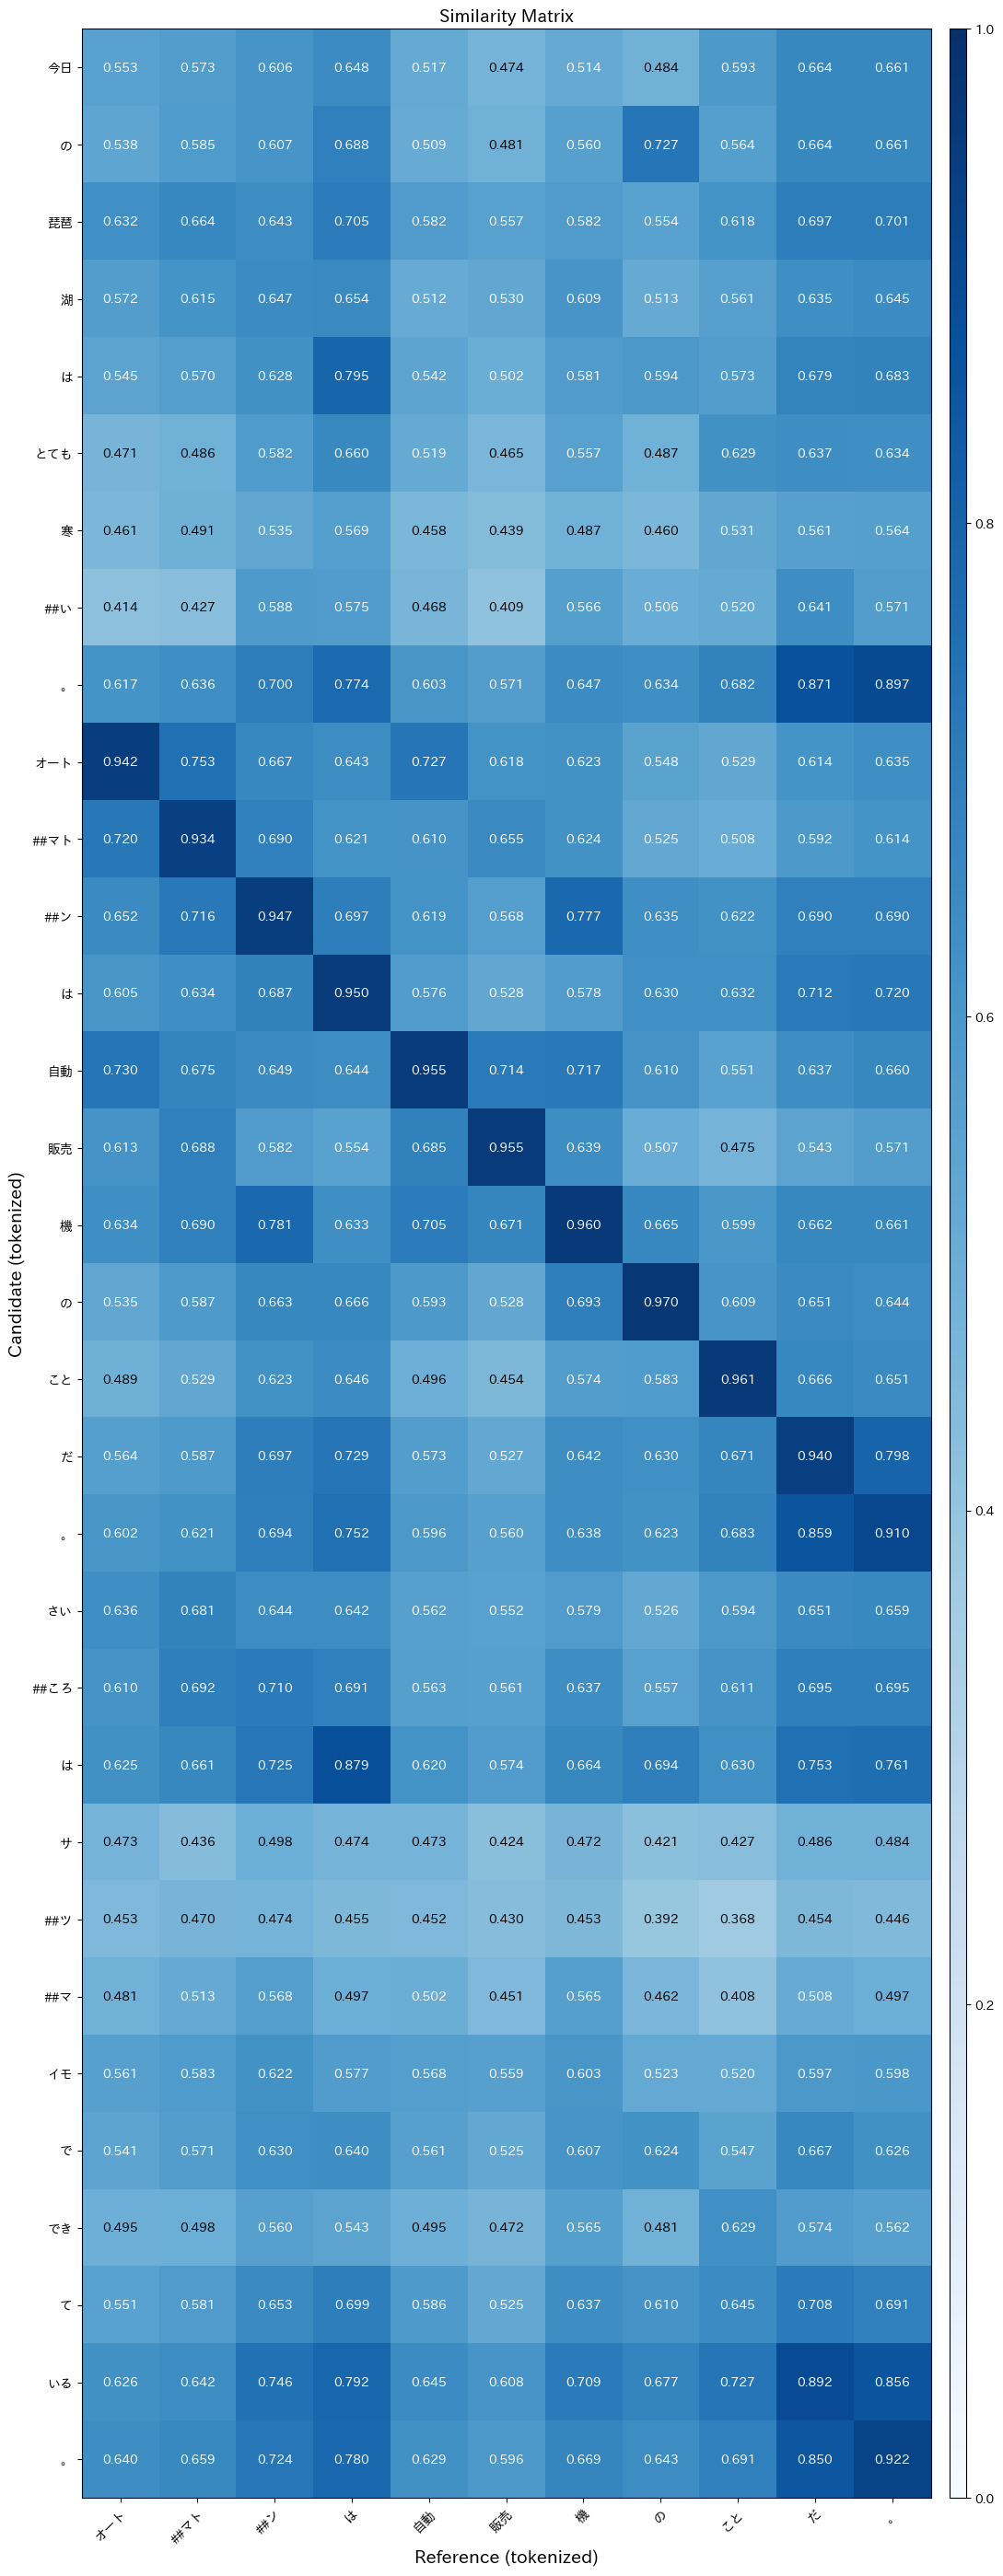

In [2]:

import pandas
import threading
from threading import Thread
from typing import List,Tuple
from pprint import pprint
import bert_score
import re
import numpy as np
import bert_score
import matplotlib.pyplot as plt
import japanize_matplotlib
from bert_score.utils import (
    get_bert_embedding,
    sent_encode,
)
import torch
from collections import defaultdict

class BERTScorer(bert_score.BERTScorer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tokenizer = self._tokenizer
        return

    def get_tokenwise_similarity(self, candidate:str, reference:str) -> Tuple[np.ndarray,List[str],List[str]]:
        """類似度行列とtokenizeされた文章を返す"""
        
        assert isinstance(candidate, str)
        assert isinstance(reference, str)

        idf_dict = defaultdict(lambda: 1.0)
        idf_dict[self._tokenizer.sep_token_id] = 0
        idf_dict[self._tokenizer.cls_token_id] = 0

        hyp_embedding, masks, padded_idf = get_bert_embedding(
            [candidate],
            self._model,
            self._tokenizer,
            idf_dict,
            device=self.device,
            all_layers=False,
        )
        ref_embedding, masks, padded_idf = get_bert_embedding(
            [reference],
            self._model,
            self._tokenizer,
            idf_dict,
            device=self.device,
            all_layers=False,
        )
        ref_embedding.div_(torch.norm(ref_embedding, dim=-1).unsqueeze(-1))
        hyp_embedding.div_(torch.norm(hyp_embedding, dim=-1).unsqueeze(-1))
        sim = torch.bmm(hyp_embedding, ref_embedding.transpose(1, 2))
        sim = sim.squeeze(0).cpu()

        r_tokens = [
            self._tokenizer.decode([i]) for i in sent_encode(self._tokenizer, reference)
        ][1:-1]
        h_tokens = [
            self._tokenizer.decode([i]) for i in sent_encode(self._tokenizer, candidate)
        ][1:-1]
        sim = sim[1:-1, 1:-1]

        if self.rescale_with_baseline:
            sim = (sim - self.baseline_vals[2].item()) / (
                1 - self.baseline_vals[2].item()
            )


        
        cand_tokens = h_tokens
        ref_tokens = r_tokens
        sim: np.ndarray = sim.numpy()

        return sim, cand_tokens, ref_tokens
    


scorer : BERTScorer = BERTScorer(lang="ja",device="cuda:0")



def sentence_splitter(s:str):
        
    # 文末表現一覧
    end_pattern : str = r'[.。?！？!]'
    
    # 文末表現で分割
    split_sentense = re.split(end_pattern, s)
    
    # 単なる改行をすべて削除
    split_sentense = list(map(lambda x: x.replace("\n",""),split_sentense))
    
    # 空文字列を削除
    split_sentense = list(filter(lambda x: x != "",split_sentense))
    
    # 文末表現をすべて削除
    for char in end_pattern:
        split_sentense = list(map(lambda x: x.replace(char,""),split_sentense))
    
    
    return split_sentense



def calc_bert_score(cands:List[str], refs:List[str]) -> tuple[np.ndarray,np.ndarray,np.ndarray]:
    """ BERTスコアの算出

    Args:
        cands ([List[str]]): [比較元の文]
        refs ([List[str]]): [比較対象の文]

    Returns:
        [(List[float], List[float], List[float])]: [(Precision, Recall, F1スコア)]
    """

    
    
    
    P, R, F = scorer.score(cands, refs, verbose=False)
    
    return P.numpy(), R.numpy(), F.numpy()

def get_hallucination_score(response:str,samples:List[str]) -> Tuple[List[float],List[float],List[float]]:
    """
    Args:
        response (str): _description_
        samples (List[str]): _description_

    Returns:
        Tuple[List[float]]: pr_scores,re_scores,f1_scores
    """
    
    r_sentences = sentence_splitter(response)
    # print("r_sentences")
    # print(r_sentences)
    
    N = len(samples)
    
    PR_scores = []
    RE_scores = []
    F1_scores = []
    
    for r in r_sentences:
        
        assert r != "", f"r is empty"
        
        # print(r)
        
        PR_scores.append(1.0)
        RE_scores.append(1.0)
        F1_scores.append(1.0)
        
        for sample in samples:
            
            sample_sentences = sentence_splitter(sample)
        

            PR_score, RE_score, F1_score = calc_bert_score([r] * len(sample_sentences),sample_sentences)
        
            assert PR_score.shape == (len(sample_sentences),), f"PR_score.shape is {PR_score.shape}"
            
            pr_score = max(PR_score) / N
            re_score = max(RE_score) / N
            f1_score = max(F1_score) / N
            
            PR_scores[-1] -= pr_score
            RE_scores[-1] -= re_score
            F1_scores[-1] -= f1_score
            
    assert len(PR_scores) == len(RE_scores) == len(F1_scores)
    assert len(PR_scores) == len(r_sentences), f"len(PR_scores) is {len(PR_scores)}, len(r_sentences) is {len(r_sentences)}"
    
    return PR_scores, RE_scores, F1_scores

def get_token_level_score(response:str,samples:List[str]) -> list[list[Tuple[str,float]]]:
    
    assert len(samples) > 0, f"len(samples) is {len(samples)}"
    
    r_sentences = sentence_splitter(response)
    

    
    

    
    all_token_level_scores: list[list[Tuple[str,float]]] = [] 
    
    for r in r_sentences:
        
        assert r != "", f"r is empty"
        
        r_token_level_scores: list[Tuple[str,float]] = []
        r_tokens = [
            scorer.tokenizer.decode([i]) for i in sent_encode(scorer.tokenizer, r)
        ][1:-1]
        
        for r_token in r_tokens:
            r_token_level_scores.append((r_token,0.0))
        
        for sample in samples:
            
            sample_sentences = sentence_splitter(sample)
        
            sim, cand_tokens, ref_tokens = scorer.get_tokenwise_similarity(r,sample)
            assert sim.shape == (len(cand_tokens),len(ref_tokens)), f"sim.shape is {sim.shape}"
            
            max_sim = sim.max(axis=1)
            
            for i,cand_token in enumerate(cand_tokens):
                assert cand_token == r_token_level_scores[i][0], f"cand_token is {cand_token}, r_token_level_scores[i][0] is {r_token_level_scores[i][0]}"
                r_token_level_scores[i] = (r_token_level_scores[i][0],r_token_level_scores[i][1] + max_sim[i])
            
            # divide by number of samples
            r_token_level_scores = list(map(lambda x: (x[0],x[1] / len(samples)),r_token_level_scores))
    
    
        all_token_level_scores.append(r_token_level_scores)
    
    # tokenから#を消す
    all_token_level_scores = list(map(lambda x: list(map(lambda y: (y[0].replace("#",""),y[1]),x)),all_token_level_scores))
    
    return all_token_level_scores
            
            

            

            
    return token_level_scores

if __name__ == "__main__":
    
    model_name = "cl-tohoku/bert-base-japanese" 
    # model_name = "nlp-waseda/roberta-base-japanese"
    model_name = "cl-tohoku/bert-large-japanese-char-v2"
    model_name = "cl-tohoku/bert-base-japanese-v3" 
    
    # use sota japanese bert roberta
    # model_type = "cl-tohoku/bert-base-japanese-whole-word-masking"
    
    import transformers
    
    # use_juman = True
    use_juman = False

    # use tohoku-bert

    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModel.from_pretrained(model_name)
    
    # tokenizer = transformers.AutoTokenizer.from_pretrained("nlp-waseda/roberta-large-japanese")
    # model = transformers.AutoModel.from_pretrained("nlp-waseda/roberta-large-japanese")
    
    
    
    scorer._tokenizer = tokenizer
    scorer.tokenizer = tokenizer
    scorer._model = model.to("cuda:0")

    
    
    


    
    response = "今日の琵琶湖はとても寒い。オートマトンは自動販売機のことだ。さいころはサツマイモでできている。"
    samples = ["オートマトンは自動販売機のことだ。","オートマトンは実は自動販売機なのである。ところで今日の琵琶湖は寒い","琵琶湖は一番大きな湖なのだよ。オートマトンは自動販売機なんだってさ。"]
    
    
    
    
    if use_juman:
        import pyknp
        jumanpp = pyknp.Juman()
        def tokenize(text):
            result = jumanpp.analysis(text)
            return [mrph.midasi for mrph in result.mrph_list()]
        
        # process response
        response = " ".join(tokenize(response))
        # process samples
        samples = list(map(lambda x: " ".join(tokenize(x)),samples))
    
    print (response)
    print (samples)
    
    PR_scores, RE_scores, F1_scores = get_hallucination_score(response,samples)

    print(PR_scores)
    print(RE_scores)
    print(F1_scores)
    
    import japanize_matplotlib
    
    
    
    sim, cand_tokens, ref_tokens = scorer.get_tokenwise_similarity(response,samples[0])
    
    from pprint import pprint
    

    
    all_token_level_scores = get_token_level_score(response,samples)
    
    pprint(all_token_level_scores)
    

    
    scorer.plot_example(response,samples[0])
    
    
    



In [2]:
import transformers

# use tohoku-bert

tokenizer = transformers.BertTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
model = transformers.BertModel.from_pretrained("cl-tohoku/bert-base-japanese")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoi

In [3]:
tokenizer.tokenize("今日の琵琶湖はとても寒い。オートマトンは自動販売機のことだ。さいころはサツマイモでできている。")

['今',
 '日',
 'の',
 '[UNK]',
 '[UNK]',
 '湖',
 'は',
 '##と',
 '##て',
 '##も',
 '寒',
 'い',
 '。',
 'オート',
 '##マト',
 '##ン',
 '##は',
 '自',
 '動',
 '販',
 '売',
 '機',
 'の',
 '##こと',
 '##だ',
 '。',
 'さい',
 '##ころ',
 '##は',
 '##サ',
 '##ツ',
 '##マイ',
 '##モ',
 '##で',
 '##で',
 '##き',
 '##てい',
 '##る',
 '。']